This notebook contains the final preparations of the data for training, and carries out the training, testing and analysis of results.

In [1]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import pandas as pd
from obspy.geodetics import gps2dist_azimuth

from sklearn.preprocessing import  MinMaxScaler
import logging
import random
import numpy as np

from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import pickle
import seaborn as sns

# Machine Learning Models

## Read Data

In [2]:
#read the parquet files of the cleaned data
sea_data = pd.read_parquet('Processed Data/SEA_data_BASELINE.parquet')
rms_data = pd.read_parquet('Processed Data/RMS_data_BASELINE.parquet')

In [3]:
#extract the latitudes and longitude pairs from the data
sea_data_pairs = sea_data.columns.tolist()

grid_lats = [float(pair.split(',')[0].strip('()')) for pair in sea_data_pairs]
grid_lons = [float(pair.split(',')[1].strip('()')) for pair in sea_data_pairs]

In [4]:
#seismic Station names and coordinates - italian station locations taken from https://terremoti.ingv.it/en/instruments/network/IV
station_names = ['AIO', 'CAVT', 'CLTA', 'CSLB', 'HAGA', 'HPAC', 'MMGO', 'MPNC', 'MSDA', 'MSRU', 'MUCR', 'PZIN', 'SOLUN', 'WDD']
station_lats = [37.9712, 37.68, 37.16, 37.94, 37.29, 36.71, 37.66, 38.15, 35.901233, 38.26, 38.04, 36.81, 38.09, 35.837299]
station_lons = [15.233, 12.76, 13.96, 14.06, 15.16, 15.04, 12.98, 15.35, 14.486952, 15.51, 14.87, 11.97, 13.53, 14.5242]

## Prepare Data Set for Each Station

In [5]:
# Find the nearest grid points to each station

#define a margin around each station to compute the distance between that station and the surrounding grid points.
#this is done so the distance is not calculated from each station to the 9,000+ grid cells, but rather those reasonably close to it

lat_margin = 0.5
lon_margin = 0.5

#define station coordinates
station_coords = list(zip(station_lats, station_lons))

#define grid coordinates
grid_coords = list(zip(grid_lats, grid_lons))

nearest_grid_points = {}

for station_name, (station_lat, station_lon) in zip(station_names, station_coords):
    #define bounding box around the station
    lat_min = station_lat - lat_margin
    lat_max = station_lat + lat_margin
    lon_min = station_lon - lon_margin
    lon_max = station_lon + lon_margin

    filtered_points = []
    
    #iterate over all grid coordinates
    for lat, lon in grid_coords:
        #check if the grid point is within the latitude and longitude bounds
        is_within_bounding_box = (lat_min <= lat <= lat_max) and (lon_min <= lon <= lon_max)
        
        #if within the ROI, add the point to the filtered list
        if is_within_bounding_box:
            filtered_points.append((lat, lon))

    #compute distances only for the filtered points
    distances = []
    for grid_point in filtered_points:
        distance, _, _ = gps2dist_azimuth(station_lat, station_lon, grid_point[0], grid_point[1])
        distances.append((distance, grid_point))

    #sort by distance and get the nearest 5 points
    distances.sort(key=lambda x: x[0])
    nearest_grid_points[station_name] = [point for _, point in distances[:5]]

In [6]:
#Function to combine data from rms and sea of nearest grid points to that station at every timestamp
def create_station_sea_rms_df(station, rms_data, sea_data, nearest_grid_points):
    #get the corresponding grid points for the station
    grid_points = nearest_grid_points[station]
    
    #extract the columns from SEA_data based on the grid points
    sea_columns = [f"({lat}, {lon})" for lat, lon in grid_points]
    
    #extract RMS data for the current station 
    rms_columns = [col for col in rms_data.columns if col.startswith(station)]
    rms_values = rms_data[rms_columns]
    #print(rms_values)

    #create the dataframe with timestamp (index), RMS value and corresponding sea data columns
    result = pd.DataFrame(index=rms_data['index//'])
    for col in rms_columns:
        result[col] = rms_values[col].values
    for col in sea_columns:
        result[col] = sea_data[col].values

    #compute mean median and mode for each row
    result['sea_mean'] = result[sea_columns].mean(axis=1)
    result['sea_median'] = result[sea_columns].median(axis=1)
    result['sea_mode'] = result[sea_columns].mode(axis=1)[0]  #if the mode returns multiple values, take the first one
    
    return result

In [7]:
#create a dictionary to store all the dataframes (one for each station)
stations_sea_rms = {}

for station in station_names:
    print(station)
    stations_sea_rms[station] = create_station_sea_rms_df(station, rms_data, sea_data, nearest_grid_points)

AIO
CAVT
CLTA
CSLB
HAGA
HPAC
MMGO
MPNC
MSDA
MSRU
MUCR
PZIN
SOLUN
WDD


In [8]:
stations_sea_rms['AIO']

,AIO/Z/0.05-0.2,AIO/Z/0.2-0.35,AIO/Z/0.35-0.5,AIO/Z/0.5-0.65,AIO/Z/0.65-0.8,AIO/Z/0.8-0.95,AIO/Z/0.95-1.1,AIO/Z/1.1-1.25,AIO/Z/1.25-1.4,AIO/Z/1.4-1.55,...,AIO/E/1.7-1.85,AIO/E/1.85-2.0,"(37.895835876464844, 15.333335876464844)","(37.9375, 15.375)","(37.895835876464844, 15.375)","(37.85416793823242, 15.333335876464844)","(37.97916793823242, 15.416667938232422)",sea_mean,sea_median,sea_mode
index//,,,,,,,,,,,,,,,,,,,,,
2018-01-01 00:00:00+00:00,-1177.401152,9.570469e-08,4.395065e-08,2.635211e-08,1.504294e-08,1.228466e-08,1.170398e-08,7.072696e-09,4.951798e-09,3.367684e-09,...,3.015038e-09,3.282874e-09,0.203,0.191,0.205,0.209,0.181,0.1978,0.203,0.181
2018-01-01 01:00:00+00:00,-1168.741538,9.545442e-08,4.554082e-08,2.739944e-08,1.617472e-08,1.297614e-08,1.296917e-08,6.846057e-09,4.983450e-09,3.455066e-09,...,3.036236e-09,3.294069e-09,0.187,0.175,0.189,0.194,0.165,0.1820,0.187,0.165
2018-01-01 02:00:00+00:00,-1154.658442,9.012828e-08,4.710841e-08,2.778390e-08,1.679221e-08,1.309314e-08,1.231415e-08,7.251900e-09,4.827073e-09,3.473249e-09,...,3.251087e-09,3.572978e-09,0.175,0.163,0.177,0.181,0.154,0.1700,0.175,0.154
2018-01-01 03:00:00+00:00,-1182.145808,8.623706e-08,4.320707e-08,2.511082e-08,1.597771e-08,1.260992e-08,1.154924e-08,6.421025e-09,4.593370e-09,3.224326e-09,...,2.949792e-09,3.106447e-09,0.166,0.155,0.168,0.172,0.146,0.1614,0.166,0.146
2018-01-01 04:00:00+00:00,-1179.702537,8.286553e-08,4.656767e-08,2.596107e-08,1.598942e-08,1.339003e-08,1.128488e-08,7.107042e-09,4.528138e-09,3.272456e-09,...,2.809070e-09,3.405516e-09,0.159,0.148,0.160,0.164,0.139,0.1540,0.159,0.139
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-31 19:00:00+00:00,-1148.765978,9.465563e-08,6.906840e-08,4.191455e-08,2.063108e-08,1.223949e-08,8.252051e-09,5.771018e-09,3.934249e-09,3.015207e-09,...,2.460845e-09,2.099133e-09,0.327,0.258,0.326,0.358,0.196,0.2930,0.326,0.196
2021-12-31 20:00:00+00:00,-1160.890571,9.417616e-08,6.996478e-08,3.858088e-08,1.823494e-08,1.221914e-08,7.779101e-09,5.495682e-09,3.958890e-09,2.757386e-09,...,2.348559e-09,1.884100e-09,0.312,0.247,0.315,0.344,0.188,0.2812,0.312,0.188
2021-12-31 21:00:00+00:00,-1148.170906,8.994636e-08,6.428183e-08,3.625617e-08,1.793131e-08,1.181989e-08,8.348819e-09,5.808163e-09,4.026388e-09,2.900551e-09,...,2.275696e-09,2.016955e-09,0.446,0.377,0.451,0.472,0.310,0.4112,0.446,0.310


In [9]:
#taken directly from Minio
def sampleIdxTrainSet(length, lenchunk, nchunks):
    '''
    Selects a reliable sample of the data avoiding 
    to sample close data that will be in the test

            Parameters:
               length (int): length of the data   
               lenchunk (int): length of each chunk in samples 
               nchunks (int): number of chuncks
               
            Returns:
                idx (list): new indexes of the rows of the data 
                                                          
    '''
    try:
        #Initizializes the list of the new indexes 
        idx = None
        
        #Fixes the maximum starting position of the chunk  
        istop = length - lenchunk  
        
        #Sets randomic starting position of a chunk 
        istart = np.random.randint(lenchunk)
        
        #Defines the position of the chunks  
        ndxs = list(range(istart, istop, lenchunk)) 

        #Selects a randomic number of chunks 
        #and sorts them
        isx = sorted(random.sample(ndxs, nchunks))
        
        #Fixed the starting index position of the chunks 
        idx = []
        for j in isx:
            idx += list(range(j, j+lenchunk))   
        return idx
    except Exception:
        #Update log file about the fall of the operation 
        logging.warning('Warning! Impossible to find a proper training set.')

# All Stations in a Loop

In [10]:
#train test val splits
train_percentage = 70
test_percentage = 20
val_percentage = 10

#number of chunks in training/test set
nchunks = 40

#number of ks for kfold cross validation
kfolds = 1

# random forest number of estimators  
RF_n_estimators = 200

# random forest maximum depth     
RF_max_depth = 15

# random forest maximum features 
RF_max_features = 40

In [26]:
results = {}
metrics = []

for station in station_names:
    print(station)
    mlvariables = stations_sea_rms[station]

    X = mlvariables.loc[:, mlvariables.columns.str.startswith(station)] #input variable is columns that start with station name
    Y = mlvariables.loc[:, ~mlvariables.columns.str.startswith(station)] #target variable are the remaining columns
    T = mlvariables.index.tolist() #Time series

    if X.columns.size != 0: #skip if blank array i.e. no data for station
        #scale values between 0 and 1
        scaler_x = MinMaxScaler()
        scaler_y = MinMaxScaler()
        
        #fit the scalers
        scaler_x.fit(X) 
        scaler_y.fit(Y)
    
        #apply the scalers
        Xscale = scaler_x.transform(X) 
        Yscale = scaler_y.transform(Y)
    
        training_size =  (mlvariables.shape[0]*train_percentage)//100
        lenchunk = round(training_size/nchunks)
        
        #Generates k-th datasets for Cross Validation 
        list_of_dataset = [{'idx': [], 'XscaleTrain': [], 'YscaleTrain': [], 'XscaleTest': [], 'YscaleTest': []} for number in range(kfolds)]
    
        for i, dic in enumerate(list_of_dataset):
        
            #Creates the training dataset 
            list_of_dataset[i]['idx'] = sampleIdxTrainSet(Xscale.shape[0], lenchunk, nchunks)
            list_of_dataset[i]['XscaleTrain'] = Xscale[list_of_dataset[i]['idx'],:] 
            list_of_dataset[i]['YscaleTrain'] = Yscale[list_of_dataset[i]['idx'],:] 
            
            #Creates the tests dataset 
            list_of_dataset[i]['XscaleTest'] = np.delete(Xscale, list_of_dataset[i]['idx'], axis=0) #test set for microseism
            list_of_dataset[i]['YscaleTest'] = np.delete(Yscale, list_of_dataset[i]['idx'], axis=0) #test set for swh
    
        print(f"Training on station: {station}")
        RF_model = RandomForestRegressor(bootstrap = True,
                                     max_depth=RF_max_depth,
                                     n_estimators=RF_n_estimators,
                                     max_features= RF_max_features,
                                     verbose=0)
    
        #Initiliaze the empty variables
        Ypred = None
        YTest = None
    
        #Applies the learning/prediction to the k datasets  
        for index, d in enumerate(list_of_dataset):    
            
            #Fits the model to training data 
            RF_model.fit(d['XscaleTrain'], d['YscaleTrain'])
            
            #Predicts the sea wave data by using the testing data 
            ypred = RF_model.predict(d['XscaleTest'])
            
            #Inverts the scaling of the data and stores the results in the predicted/testing arrays
            Ypred = scaler_y.inverse_transform(ypred)if Ypred is None else np.concatenate([Ypred, scaler_y.inverse_transform(ypred)], axis =0) 
            YTest = scaler_y.inverse_transform(d['YscaleTest']) if YTest is None else np.concatenate([YTest, scaler_y.inverse_transform(d['YscaleTest'])], axis =0)
    
        #store the results for the current station in the results dictionary
        results[station] = {'Ypred': Ypred, 'YTest': YTest}
    
        #CALCULATE ERROR METRICS
        #the names of the target variables are the last eight columns of the station data
        target_names = Y.columns.tolist()
        
        for i, target in enumerate(target_names):
            mae = mean_absolute_error(YTest[:, i], Ypred[:, i])
            mse = mean_squared_error(YTest[:, i], Ypred[:, i])
            rmse = np.sqrt(mse)
            r2 = r2_score(YTest[:, i], Ypred[:, i])
        
            #append the results as a row
            metrics.append([station, target, RF_max_depth, RF_n_estimators, RF_max_features, mae, mse, rmse, r2])
        
#creates results dataframe
metrics_df = pd.DataFrame(metrics, columns=["Station", "Target Variable", "RF_max_depth", "RF_n_estimators", "RF_max_features", "MAE", "MSE", "RMSE", "R2"])

#save the results to csv
metrics_df.to_csv(f"results/BASLEINE-error_metrics.csv", index=False)

AIO
Training on station: AIO
CAVT
CLTA
CSLB
Training on station: CSLB
HAGA
Training on station: HAGA
HPAC
MMGO
Training on station: MMGO
MPNC
Training on station: MPNC
MSDA
Training on station: MSDA
MSRU
MUCR
Training on station: MUCR
PZIN
SOLUN
Training on station: SOLUN
WDD
Training on station: WDD


In [25]:
if X.columns.size != 0:
    print("TRUE")

#save the dictionary as a pickle file
with open('results/results_20250206.pkl', 'wb') as file:
    pickle.dump(results, file)

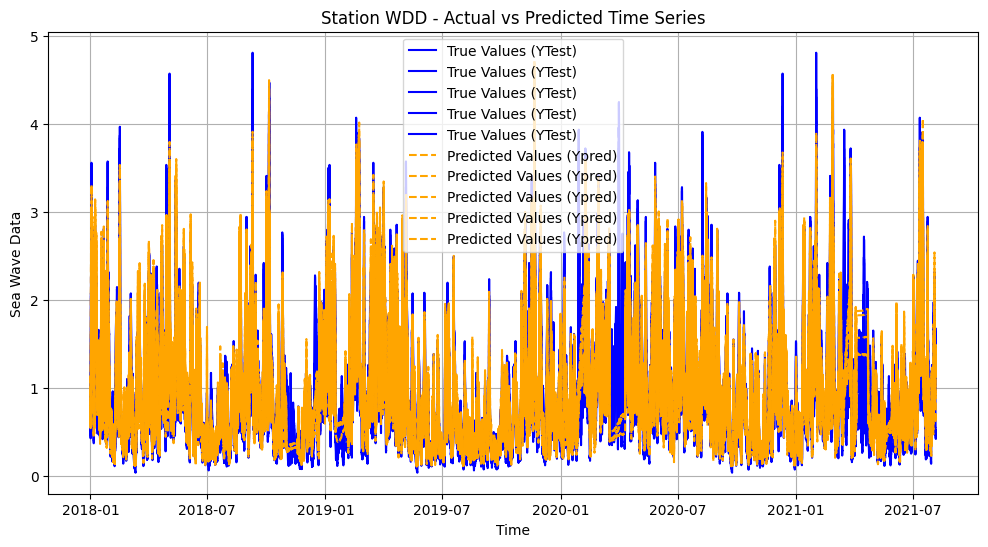

In [26]:
station = 'WDD'

YTest_station = results[station]['YTest']
Ypred_station = results[station]['Ypred']

#create a time series index
time_series_index = mlvariables.index

#plot ytest and ypred
plt.figure(figsize=(12, 6))
plt.plot(time_series_index[:len(YTest_station)], YTest_station, label='True Values (YTest)', color='blue')
plt.plot(time_series_index[:len(Ypred_station)], Ypred_station, label='Predicted Values (Ypred)', color='orange', linestyle='dashed')


plt.title(f'Station {station} - Actual vs Predicted Time Series')
plt.xlabel('Time')
plt.ylabel('Sea Wave Data')
plt.legend()
plt.grid(True)
plt.show()

In [28]:
results[station]['YTest'].shape

(31506, 5)

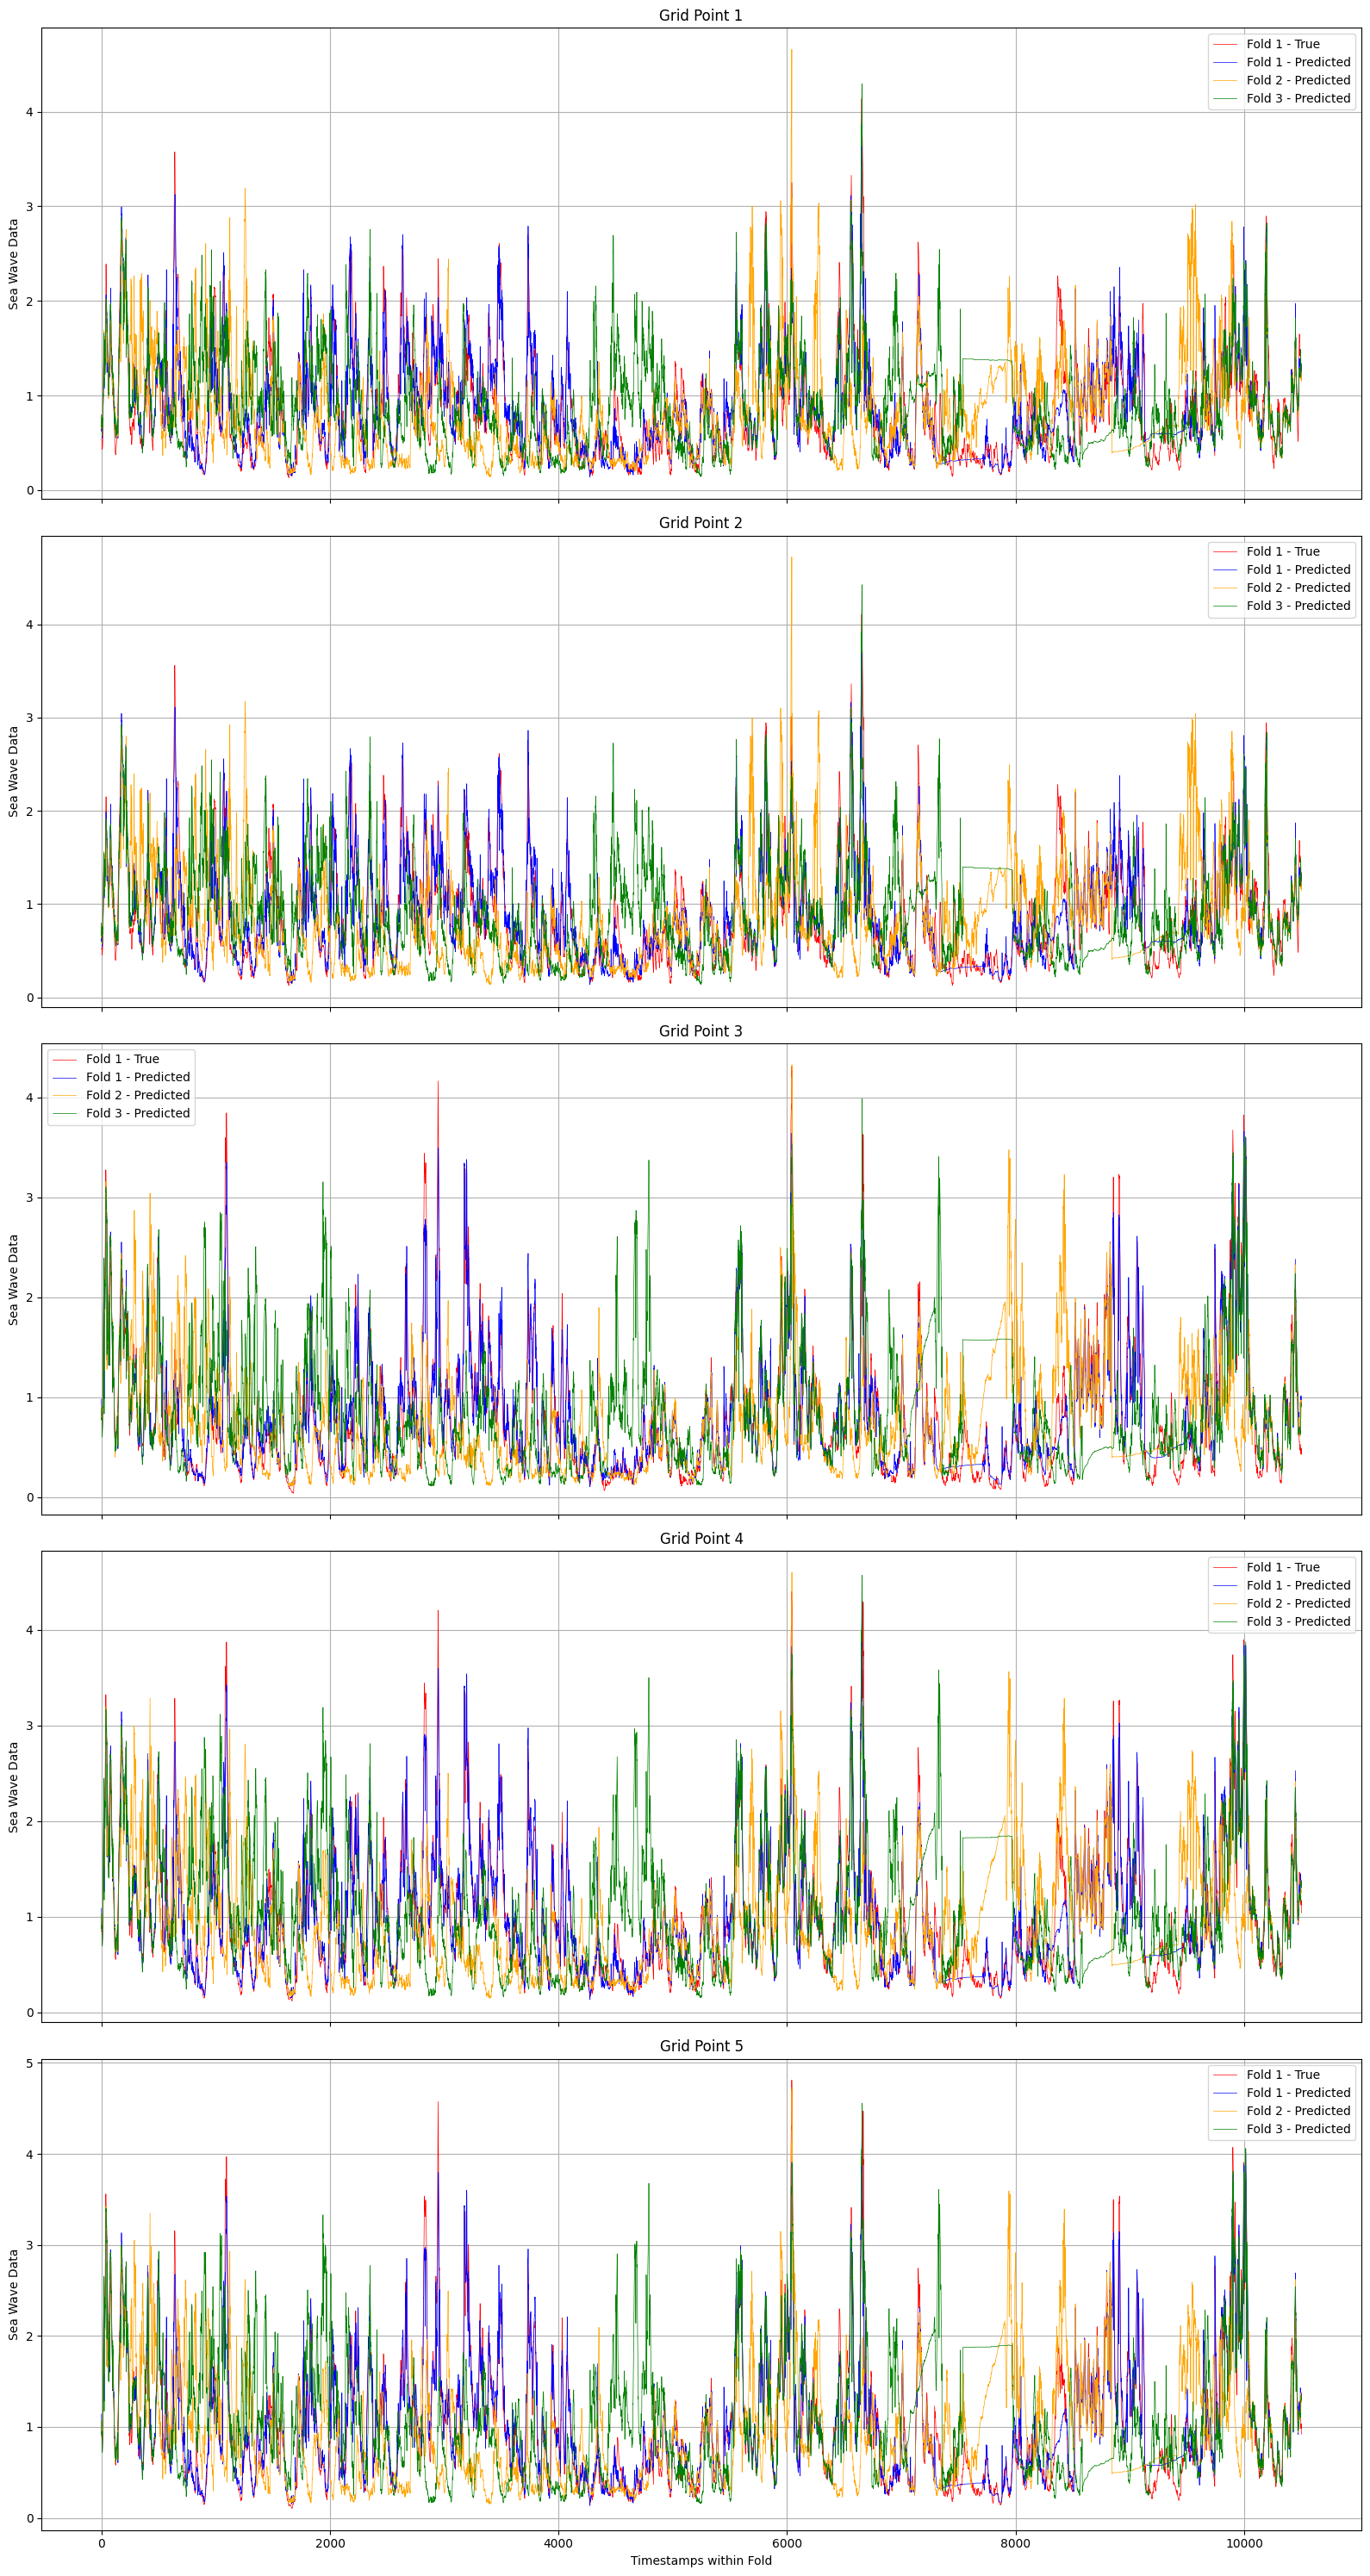

In [50]:
station = 'WDD'

YTest_station = results[station]['YTest']
Ypred_station = results[station]['Ypred']

#YTest_station has shape (31506, 5) corresponding to 3 folds × 10502 timestamps, 5 grid points
timestamps_per_fold = YTest_station.shape[0] // kfolds
gridpoints = YTest_station.shape[1]

colours = ['blue', 'orange', 'green']
fold_labels = ['Fold 1', 'Fold 2', 'Fold 3']

#create subplots for each grid point
fig, axes = plt.subplots(gridpoints, 1, figsize=(16, 6 * gridpoints), sharex=True)

for gp in range(gridpoints):
    ax = axes[gp] #place plots in the respective grid's subplot 
    for fold_idx in range(kfolds): #iterate over folds to plot within the subplot
        start_idx = fold_idx * timestamps_per_fold
        end_idx = start_idx + timestamps_per_fold

        #plot true values once, only for the first fold
        if fold_idx == 0:
            ax.plot(range(timestamps_per_fold), YTest_station[start_idx:end_idx, gp], linewidth=0.5, color='RED', label=f'{fold_labels[fold_idx]} - True')

        #plot the predicted values for all the folds
        ax.plot(range(timestamps_per_fold), Ypred_station[start_idx:end_idx, gp], linewidth=0.5, color=colours[fold_idx], label=f'{fold_labels[fold_idx]} - Predicted')

    ax.set_title(f'Grid Point {gp + 1}')
    ax.set_ylabel('Sea Wave Data')
    ax.legend()
    ax.grid(True)

plt.xlabel('Timestamps within Fold')
plt.tight_layout()
plt.show()

In [51]:
mae = mean_absolute_error(YTest_station, Ypred_station)

mse = mean_squared_error(YTest_station, Ypred_station)

rmse = np.sqrt(mse)

r2 = r2_score(YTest_station, Ypred_station)

#Print the results
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"R² (Coefficient of Determination): {r2}")

Mean Absolute Error (MAE): 0.16337800074955725
Mean Squared Error (MSE): 0.07130747006083195
Root Mean Squared Error (RMSE): 0.26703458588885437
R² (Coefficient of Determination): 0.8148935211405984


In [52]:
for gp in range(gridpoints):
    print(f"Grid Point: {gp}")
    for fold_idx in range(kfolds): #iterate over folds to plot within the subplot
        print(f"    Fold: {fold_idx}")
        start_idx = fold_idx * timestamps_per_fold
        end_idx = start_idx + timestamps_per_fold

        mae = mean_absolute_error(YTest_station[start_idx:end_idx, gp], Ypred_station[start_idx:end_idx, gp])
        
        mse = mean_squared_error(YTest_station[start_idx:end_idx, gp], Ypred_station[start_idx:end_idx, gp])
        
        rmse = np.sqrt(mse)
        
        r2 = r2_score(YTest_station[start_idx:end_idx, gp], Ypred_station[start_idx:end_idx, gp])
        
        #Print the results
        print(f"        Mean Absolute Error (MAE): {mae}")
        print(f"        Mean Squared Error (MSE): {mse}")
        print(f"        Root Mean Squared Error (RMSE): {rmse}")
        print(f"        R² (Coefficient of Determination): {r2}")

Grid Point: 0
    Fold: 0
        Mean Absolute Error (MAE): 0.16879919017869519
        Mean Squared Error (MSE): 0.056595167007128674
        Root Mean Squared Error (RMSE): 0.23789738755843595
        R² (Coefficient of Determination): 0.8109323610848882
    Fold: 1
        Mean Absolute Error (MAE): 0.1979615880044783
        Mean Squared Error (MSE): 0.11482066614733469
        Root Mean Squared Error (RMSE): 0.33885198265221156
        R² (Coefficient of Determination): 0.7025017817557332
    Fold: 2
        Mean Absolute Error (MAE): 0.17410084100671863
        Mean Squared Error (MSE): 0.06779588970611461
        Root Mean Squared Error (RMSE): 0.26037643846192116
        R² (Coefficient of Determination): 0.7662703264441131
Grid Point: 1
    Fold: 0
        Mean Absolute Error (MAE): 0.16851495317018542
        Mean Squared Error (MSE): 0.0563943302694171
        Root Mean Squared Error (RMSE): 0.23747490450449096
        R² (Coefficient of Determination): 0.8161533932207031
 